# Cross Entropy Loss Example on Smart Grid Stability Dataset

Binary Cross Entropy: Berechnet wie weit die vorhergesagten Wahrscheinlichkeit $p_i$ von den tatsächlichen Labels $y_i$ entfernt sind.
$$
L = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right] \quad p_i = \hat{y}_i
$$

- wenn $y_i = 1$, dann wird nur der erste Term berücksichtigt: $\log(p_i)$
- wenn Wahrscheinlichkeit $p_i$ nahe bei 1 ist, ist der Verlust gering
- wenn Wahrscheinlichkeit $p_i$ nahe bei 0 ist, ist der Verlust hoch -> Modell wird bestraft

# Confusion Matrix

|               | Vorhersage 0 (Stable)| Vorhersage 1 (Unstable) |
|---------------|--------------------|--------------------|
| Realität 0 | True Positive (**TP**)  | False Negative (**FN**) |
| Realität 1 | False Positive (**FP**) | True Negative (**TN**)  |

- **TP**: Modell sagt stabil voraus, und es ist stabil (Korrekte Vorhersage)
- **TN**: Modell sagt instabil voraus, und es ist instabil (Korrekte Vorhersage)
- **FP**: Modell sagt stabil voraus, aber es ist instabil (Falsche Vorhersage)
- **FN**: Modell sagt instabil voraus, aber es ist stabil (Falsche Vorhersage)

# Classification Report

- $\text{Precision} = \frac{TP}{TP + FP}$ (Genauigkeit der positiven Vorhersagen)
- $\text{Recall} = \frac{TP}{TP + FN}$ (Erkennungsrate der positiven Fälle)
- $F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$ (F1-Score, harmonisches Mittel von Precision und Recall)

In [103]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import set_seed
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


random_seed = 42
set_seed(random_seed)


In [104]:
batch_size = 256
lr = 0.001
epochs = 500

# Data Preparation

- Soruce: [Dataset](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)
- Features (1 = Erzeuger, 234 = Verbraucher)
  - **tau1-4**: Reaktionszeiten der Teilnehmer
  - **p1-4**: Nominale Leistung (Erzeugung vs. Verbrauch)
  - **g1-4**: Preiselastizität (wie stark reagieren Teilnehmer auf Preisänderungen?)
- Label: 
  - **Klassifikation**: stable vs. unstable
  

In [105]:
raw_data = pd.read_csv("datasets/smart_grid_dataset.csv")
raw_data.drop(columns=['stab'], inplace=True) # delete stab column
raw_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


### Normalizing Data

In [106]:
features = ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4']
label = 'stabf'
norm_data = raw_data.copy()

# Min-Max Normalization
for feature in features:
  minVal = raw_data[feature].min()
  maxVal = raw_data[feature].max()

  norm_data[feature] = (norm_data[feature] - minVal) / (maxVal - minVal)
  norm_data[feature] = 2 * norm_data[feature] - 1

# Convert Labels (stable, unstable) to (0, 1)
norm_data[label] = norm_data[label].map({'stable': 0, 'unstable': 1})


norm_data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.000028,0.000003,-0.000024,0.000008,0.012376,-0.000001,0.000012,-0.000032,0.000056,0.000003,-0.000037,0.000044,0.638000
std,0.577459,0.577397,0.577460,0.577443,0.351327,0.577463,0.577429,0.577418,0.577424,0.577445,0.577422,0.577438,0.480603
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,-0.500120,-0.499984,-0.499986,-0.500056,-0.235976,-0.499942,-0.500065,-0.500012,-0.499937,-0.499946,-0.500046,-0.500020,0.000000
50%,-0.000027,-0.000002,-0.000030,-0.000047,0.012855,0.000044,0.000046,-0.000042,0.000076,0.000009,-0.000006,0.000047,1.000000
75%,0.499977,0.499996,0.500034,0.500029,0.261064,0.500102,0.499996,0.499914,0.499957,0.500040,0.499875,0.499954,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split Data & Create Dataloaders

In [107]:
trainSize = 0.7
valSize = 0.15
testSize = 0.15

X = norm_data[features].values # (10000, 12)
y = norm_data[label].values # (10000, 1)

# Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=testSize, random_state=random_seed, shuffle=True) # split off test set
relative_val_size = valSize / (trainSize + valSize) # adjust validation size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=relative_val_size, random_state=random_seed, shuffle=True) # split train and validation set

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

# Convert to Pytorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


(7000, 12) (1500, 12) (1500, 12)
(7000,) (1500,) (1500,)


# Model

In [108]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [109]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, device="cuda"):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device

        self.train_losses = []
        self.val_losses = []

    def train_step(self, batch_x, batch_y):
        self.model.train()
        self.optimizer.zero_grad()

        preds = self.model(batch_x)
        loss = self.loss_fn(preds, batch_y)

        loss.backward()
        self.optimizer.step()

        return loss.item()

    @torch.no_grad()
    def val_step(self, batch_x, batch_y):
        self.model.eval()
        preds = self.model(batch_x)
        loss = self.loss_fn(preds, batch_y)
        return loss.item()

    def fit(self, train_loader, val_loader, epochs=100, print_status=True):
        #print("Starting training...")
        for epoch in range(epochs):
            batch_train_losses = []

            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                loss = self.train_step(xb, yb)
                batch_train_losses.append(loss)

            avg_train = np.mean(batch_train_losses)
            self.train_losses.append(avg_train)

            # validation
            val_losses = []
            for xb, yb in val_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                val_losses.append(self.val_step(xb, yb))

            avg_val = np.mean(val_losses)
            self.val_losses.append(avg_val)

            if print_status and (epoch+1) % 50 == 0:
                clear_output(wait=True)
                print(f"Epoch {epoch+1}/{epochs} | Train: {avg_train:.7f} | Val: {avg_val:.7f}")

    @torch.no_grad()
    def test(self, test_loader):
        losses = []
        for xb, yb in test_loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            preds = self.model(xb)
            losses.append(self.loss_fn(preds, yb).item())

        return np.mean(losses)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_performance(self, loader, title="Confusion Matrix"):
        self.model.eval()
        all_preds = []
        all_labels = []

        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)

            # Vorhersage berechnen
            outputs = self.model(xb)

            # Bei CrossEntropy nehmen wir den Index mit dem höchsten Wert (Logit)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

        # 1. Confusion Matrix berechnen
        cm = confusion_matrix(all_labels, all_preds)

        # 2. Plotten
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['stable', 'unstable'],
                    yticklabels=['stable', 'unstable'])
        plt.xlabel('Vorhersage (Modell)')
        plt.ylabel('Realität (Daten)')
        plt.title(title)
        plt.show()

        # 3. Textueller Report (Precision, Recall, F1-Score)
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=['stable', 'unstable']))

    def save(self, path="model.pt"):
        torch.save(self.model.state_dict(), path)

Epoch 500/500 | Train: 0.0674913 | Val: 0.0979010
Test Loss XY: 0.1098


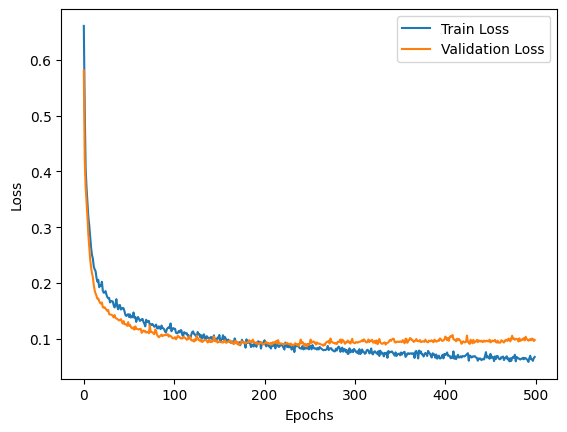

In [110]:
model = NNModel()
trainer = Trainer(model=model, loss_fn=nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(model.parameters(), lr=lr))
trainer.fit(train_loader, val_loader, epochs)

test_loss = trainer.test(test_loader)
print(f'Test Loss XY: {test_loss:.4f}')

trainer.plot_losses()



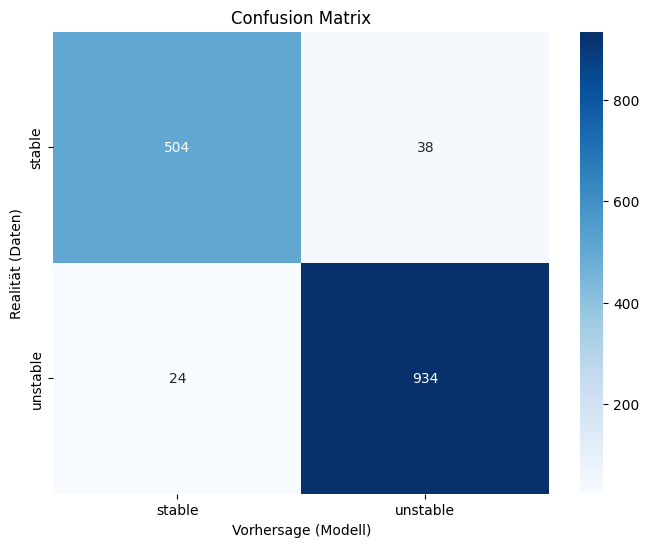


Classification Report:
              precision    recall  f1-score   support

      stable       0.95      0.93      0.94       542
    unstable       0.96      0.97      0.97       958

    accuracy                           0.96      1500
   macro avg       0.96      0.95      0.95      1500
weighted avg       0.96      0.96      0.96      1500



In [111]:
trainer.evaluate_performance(test_loader)

# Zusammenfassung der Ergebnisse

- True Positves = 504 und True Negatives = 934 -> Insgesamt 1438 korrekte Vorhersagen -> Mehrheit der Netzzustände wird korrekt klassifiziert
- False Positives = 38 -> „Blinder Alarm“. Das Netz ist stabil, die KI warnt jedoch. Dies führt zu unnötigen Systemprüfungen, gefährdet aber nicht die Versorgungssicherheit
- False Negatives = 20 -> Kritisch, da instabile Netzzustände als stabil eingestuft werden. Dies kann zu Stromausfällen führen. Die geringe Anzahl zeigt jedoch die Effektivität des Modells bei der Erkennung instabiler Zustände